In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# read json file
df = pd.read_json('df_slim_rotterdam.json', orient='records') # changed if testing with df_wide



,navigation.time,navigation.location.long,navigation.location.lat,navigation.destination.name,navigation.destination.eta,navigation.status,device.mmsi,vessel.type,vessel.imo,vessel.name,day,hour,minute
0,1609459588000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,6
1,1609459769000,4.00827,51.95786,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,9
2,1609459948000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,12
3,1609459948000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,12
4,1609460669000,4.00828,51.95786,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30038,1611940618000,4.51208,51.83224,RDAM-BERGEN OP ZOOM,None,under-way-using-engine,244670295,other,0,ROMEE,29,17,16
30039,1611940919000,4.53372,51.83036,RDAM-BERGEN OP ZOOM,None,under-way-using-engine,244670295,other,0,ROMEE,29,17,21
30040,1611941219000,4.55464,51.82853,RDAM-BERGEN OP ZOOM,None,under-way-using-engine,244670295,other,0,ROMEE,29,17,26
30041,1611941520000,4.56225,51.81571,RDAM-BERGEN OP ZOOM,None,under-way-using-engine,244670295,other,0,ROMEE,29,17,32


In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns for clustering
numerical_columns = ['navigation.location.long', 'navigation.location.lat']
data = df[numerical_columns]

# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply k-means clustering
kmeans = KMeans(n_clusters=5, init= 'k-means++', random_state=42)  # Adjust n_clusters as needed
df['cluster'] = kmeans.fit_predict(data_scaled)


# Show the centroids of the clusters
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=numerical_columns)
centroids_df['cluster'] = range(len(centroids_df))
centroids_df[['cluster'] + numerical_columns].head()

# Display the first few rows with cluster labels
df[['navigation.location.long', 'navigation.location.lat', 'cluster']].head()


,navigation.location.long,navigation.location.lat,cluster
0,4.00828,51.95784,2
1,4.00827,51.95786,2
2,4.00828,51.95784,2
3,4.00828,51.95784,2
4,4.00828,51.95786,2


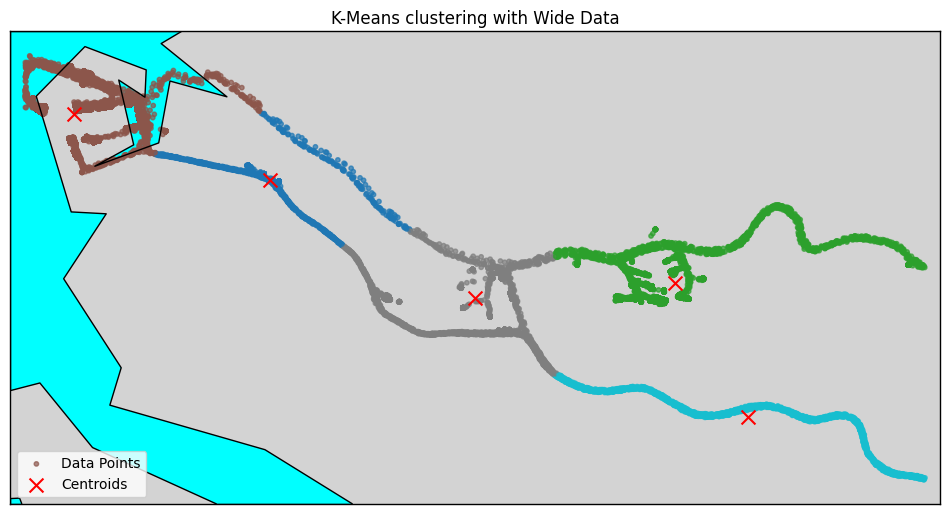

In [4]:
from mpl_toolkits.basemap import Basemap

# Initialize the Basemap
plt.figure(figsize=(12, 8))
m = Basemap(projection='merc', 
            llcrnrlat=df['navigation.location.lat'].min() - 0.01, 
            urcrnrlat=df['navigation.location.lat'].max() + 0.01,
            llcrnrlon=df['navigation.location.long'].min() - 0.01, 
            urcrnrlon=df['navigation.location.long'].max() + 0.01,
            resolution='i')

# Draw map details
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='lightgray', lake_color='aqua')

# Plot the data points
x, y = m(df['navigation.location.long'].values, df['navigation.location.lat'].values)
m.scatter(x, y, c=df['cluster'], cmap='tab10', marker='o', s=10, alpha=0.7, label='Data Points')

# Plot the centroids
centroid_x, centroid_y = m(centroids[:, 0], centroids[:, 1])
m.scatter(centroid_x, centroid_y, c='red', marker='x', s=100, label='Centroids')

# Add legend and title
plt.legend(loc='lower left')
plt.title('K-Means clustering with Wide Data')
plt.show()

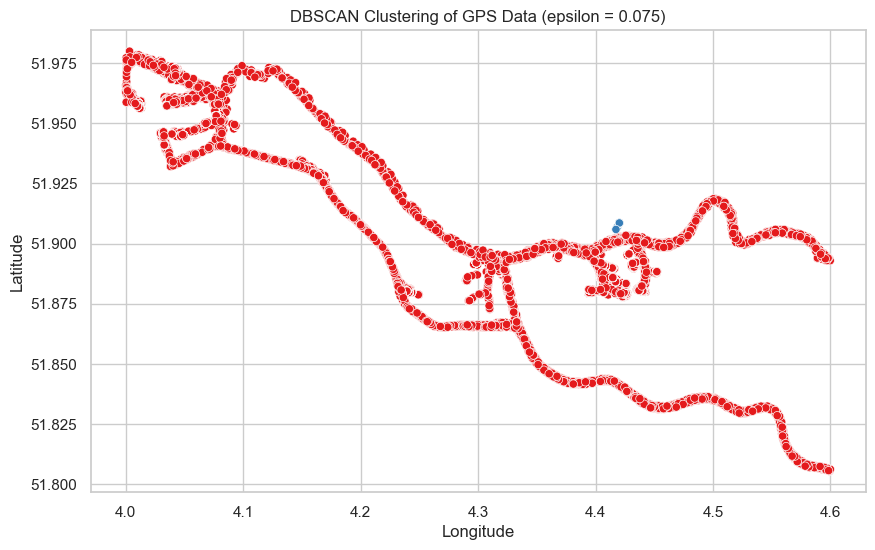

,navigation.location.long,navigation.location.lat,dbscan_cluster
0,4.00828,51.95784,0
1,4.00827,51.95786,0
2,4.00828,51.95784,0
3,4.00828,51.95784,0
4,4.00828,51.95786,0


In [12]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
eps = 0.075 # fpr testing diff values
dbscan = DBSCAN(eps=eps, min_samples=5)  
df['dbscan_cluster'] = dbscan.fit_predict(data_scaled)

# Plot the DBSCAN clusters without legend
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='navigation.location.long', y='navigation.location.lat', hue='dbscan_cluster', palette='Set1', legend=False)
plt.title(f'DBSCAN Clustering of GPS Data (epsilon = {eps})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Display the first few rows with DBSCAN cluster labels
df[['navigation.location.long', 'navigation.location.lat', 'dbscan_cluster']].head()


In [7]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=5)  
df['hierarchical_cluster'] = hierarchical.fit_predict(data_scaled)


# Calculate the mean of the coordinates for each cluster
cluster_means = df.groupby('cluster')[['navigation.location.long', 'navigation.location.lat']].mean().reset_index()
cluster_means.columns = ['cluster', 'mean_longitude', 'mean_latitude']
cluster_means['mean_longitude'] = cluster_means['mean_longitude'].astype(float)
cluster_means['mean_latitude'] = cluster_means['mean_latitude'].astype(float)

# Display the first few rows with hierarchical cluster labels
df[['navigation.location.long', 'navigation.location.lat', 'hierarchical_cluster']].head()



,navigation.location.long,navigation.location.lat,hierarchical_cluster
0,4.00828,51.95784,1
1,4.00827,51.95786,1
2,4.00828,51.95784,1
3,4.00828,51.95784,1
4,4.00828,51.95786,1


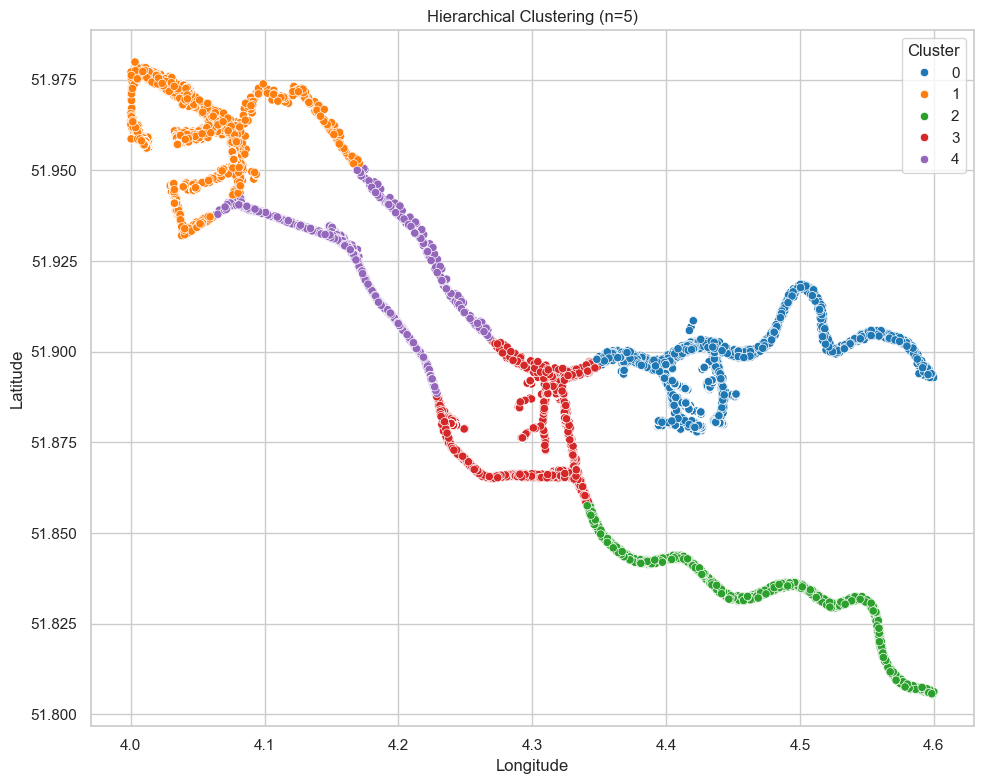

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Plot the data points, colored by their hierarchical cluster label
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x='navigation.location.long',
    y='navigation.location.lat',
    hue='hierarchical_cluster',
    palette='tab10',  
    legend='full'
)

plt.title('Hierarchical Clustering (n=5)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import adjusted_rand_score

# Calculate Adjusted Rand Index (ARI)
ari = adjusted_rand_score(df['cluster'], df['hierarchical_cluster'])
print(f"Adjusted Rand Index (ARI): {ari}")


Adjusted Rand Index (ARI): 0.9828775119305406


In [10]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(df['cluster'], df['hierarchical_cluster'])
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[    0    18     0     0  1591]
 [ 6498     0     0     0     0]
 [    0 14248     0     0    77]
 [    9     0    85  6100   143]
 [    0     0  1274     0     0]]


In [11]:
# Calculate Pearson correlation coefficient
correlation = df['cluster'].corr(df['hierarchical_cluster'])
print(f"Pearson correlation coefficient: {correlation}")


Pearson correlation coefficient: 0.38621722994797164
